In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [28]:
import pandas as pd

# Load the dataset
data = pd.read_csv("../data/Weather Dataset.csv")

# Inspect first few rows
print(data.head())

# Check columns
print(data.columns)


          Date/Time  Temp_C  Dew Point Temp_C  Rel Hum_%  Wind Speed_km/h  \
0  01-01-2012 00:00    -1.8              -3.9         86                4   
1  01-01-2012 01:00    -1.8              -3.7         87                4   
2  01-01-2012 02:00    -1.8              -3.4         89                7   
3  01-01-2012 03:00    -1.5              -3.2         88                6   
4  01-01-2012 04:00    -1.5              -3.3         88                7   

   Visibility_km  Press_kPa               Weather  
0            8.0     101.24                   Fog  
1            8.0     101.24                   Fog  
2            4.0     101.26  Freezing Drizzle,Fog  
3            4.0     101.27  Freezing Drizzle,Fog  
4            4.8     101.23                   Fog  
Index(['Date/Time', 'Temp_C', 'Dew Point Temp_C', 'Rel Hum_%',
       'Wind Speed_km/h', 'Visibility_km', 'Press_kPa', 'Weather'],
      dtype='object')


In [30]:
import pandas as pd

# Load dataset
data = pd.read_csv("../data/Weather Dataset.csv")

# Rename columns for convenience
data = data.rename(columns={
    'Temp_C': 'temp',
    'Rel Hum_%': 'humidity',
    'Press_kPa': 'pressure',
    'Wind Speed_km/h': 'wind_speed',
    'Date/Time': 'timestamp'
})

# Convert timestamp safely
data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True, errors='coerce')

# Drop rows with invalid timestamps
data = data.dropna(subset=['timestamp'])

# Inspect
print(data.head())
print(data.dtypes)


            timestamp  temp  Dew Point Temp_C  humidity  wind_speed  \
0 2012-01-01 00:00:00  -1.8              -3.9        86           4   
1 2012-01-01 01:00:00  -1.8              -3.7        87           4   
2 2012-01-01 02:00:00  -1.8              -3.4        89           7   
3 2012-01-01 03:00:00  -1.5              -3.2        88           6   
4 2012-01-01 04:00:00  -1.5              -3.3        88           7   

   Visibility_km  pressure               Weather  
0            8.0    101.24                   Fog  
1            8.0    101.24                   Fog  
2            4.0    101.26  Freezing Drizzle,Fog  
3            4.0    101.27  Freezing Drizzle,Fog  
4            4.8    101.23                   Fog  
timestamp           datetime64[ns]
temp                       float64
Dew Point Temp_C           float64
humidity                     int64
wind_speed                   int64
Visibility_km              float64
pressure                   float64
Weather               

C:\Users\vivek\AppData\Local\Temp\ipykernel_23436\2199846415.py:16: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True, errors='coerce')


In [31]:
# Extract hour, minute, second, day, month, year
data['hour'] = data['timestamp'].dt.hour
data['minute'] = data['timestamp'].dt.minute
data['second'] = data['timestamp'].dt.second
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['year'] = data['timestamp'].dt.year


In [32]:
# Temperature and humidity changes from previous row
data['temp_delta'] = data['temp'].diff().fillna(0)
data['humidity_delta'] = data['humidity'].diff().fillna(0)


In [33]:
# Simple binary rain indicator
def rain_flag(weather_desc):
    weather_desc = str(weather_desc).lower()
    if 'rain' in weather_desc or 'drizzle' in weather_desc or 'snow' in weather_desc:
        return 1
    return 0

data['rain_1h'] = data['Weather'].apply(rain_flag)

# Rolling sums for rain over 3h, 6h, 24h
data['rain_3h'] = data['rain_1h'].rolling(3).sum().fillna(0)
data['rain_6h'] = data['rain_1h'].rolling(6).sum().fillna(0)
data['rain_24h'] = data['rain_1h'].rolling(24).sum().fillna(0)

# For simplicity, set intensity equal to 1h rain
data['rain_intensity'] = data['rain_1h']


In [36]:
feature_columns = [
    "temp", "humidity", "pressure", "wind_speed",
    "rain_1h", "rain_3h", "rain_6h", "rain_24h", "rain_intensity",
    "temp_delta", "humidity_delta",
    "hour", "minute", "second", "day", "month", "year"
]

processed_data = data[feature_columns]

# Save processed dataset
processed_data.to_csv("../data/processed/weather_processed.csv", index=False)
print("✅ Dataset ready for model training!")


✅ Dataset ready for model training!


In [37]:
import pandas as pd

# Load processed dataset
data = pd.read_csv("../data/processed/weather_processed.csv")

# Add a simple target column (flood risk) if not already present
# For demonstration, let's create a synthetic flood label based on heavy rainfall
data['flood_risk'] = ((data['rain_24h'] >= 3) | (data['rain_intensity'] == 1)).astype(int)

# Separate features and target
X = data.drop(columns=['flood_risk'])
y = data['flood_risk']

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Data ready for training:")
print(X_train.shape, X_test.shape)


✅ Data ready for training:
(2764, 17) (692, 17)


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define small hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("✅ Best hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Accuracy: 1.0
F1 Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       383
           1       1.00      1.00      1.00       309

    accuracy                           1.00       692
   macro avg       1.00      1.00      1.00       692
weighted avg       1.00      1.00      1.00       692



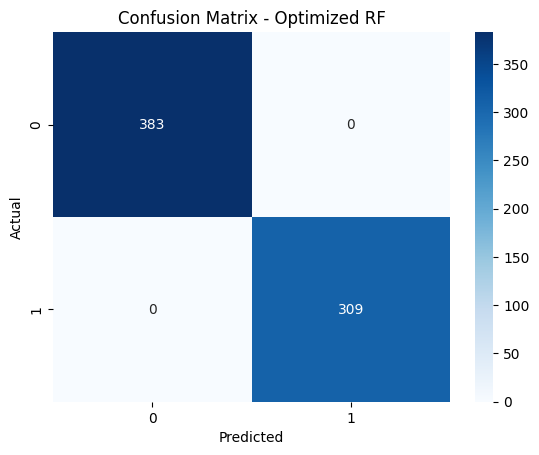

In [39]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", acc)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Optimized RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [40]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("Flood_Risk_Prediction")

with mlflow.start_run(run_name="Optimized_RF_Model"):
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)
    mlflow.sklearn.log_model(best_model, "optimized_rf_model")
    
print("✅ Optimized model logged in MLflow!")


✅ Optimized model logged in MLflow!


c:\Users\vivek\anaconda3\envs\urban_flood\Lib\site-packages\_distutils_hack\__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\vivek\anaconda3\envs\urban_flood\Lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [42]:
import joblib
import json

# Save model for API
joblib.dump(best_model, "../models/optimized_rf_model.pkl")
print("✅ Optimized model saved as models/optimized_rf_model.pkl")

# Save feature columns
feature_columns = X.columns.tolist()
with open("../models/feature_columns.json", "w") as f:
    json.dump(feature_columns, f)
print("✅ Feature columns saved!")


✅ Optimized model saved as models/optimized_rf_model.pkl
✅ Feature columns saved!
